# Import & Raw Cleaner Functions

In [ ]:
#run this every time for now, there's a way to add it to the colab config files but it's a to-do
!pip install fuzzywuzzy[speedup]

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 50 kB 4.2 MB/s 
  Created wheel for python-levenshtein: filename=python_Levenshtein-0.12.2-cp37-cp37m-linux_x86_64.whl size=149874 sha256=3a53b69591f013253f22ba8dfad451a46a0f8e64349a8dc0bce684b2b892119e
  Stored in directory: /root/.cache/pip/wheels/05/5f/ca/7c4367734892581bb5ff896f15027a932c551080b2abd3e00d
Successfully built python-levenshtein


In [ ]:
### Run cells from here through the helper functions on load! Select either raw or pickle import

import pandas as pd
import numpy as np
import re
import math
import matplotlib.pyplot as plt
import statsmodels.formula.api as sm
import seaborn as sns
from fuzzywuzzy import fuzz
import plotly.express as px
import plotly.graph_objects as go
import scipy.stats as stats
import altair as alt

pd.options.mode.chained_assignment = None
pd.set_option('display.float_format', lambda x: '%.5f' % x)
pd.set_option('display.max_rows', 500)

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
#uncomment if the raw csv is needed instead of the pickled df
  #bgg_df = pd.read_csv('https://media.githubusercontent.com/media/canunj/BGG_KS_Analysis/main/BGG_Data.csv')
  #bgg_df.to_pickle('bgg_df.pkl')

  #kick_df = pd.read_csv('https://media.githubusercontent.com/media/canunj/BGG_KS_Analysis/main/KICK_Data.csv')
  #kick_df.to_pickle('kick_df.pkl')

In [ ]:
#Initial import pickled dataframes
bgg_df = pd.read_pickle('https://media.githubusercontent.com/media/canunj/BGG_KS_Analysis/main/Staging_Files/bgg_df.pkl')
kick_df = pd.read_pickle('https://media.githubusercontent.com/media/canunj/BGG_KS_Analysis/main/Staging_Files/kick_df.pkl')

#manually cleaned ranked items (un-merged)
rank_bg_ks = pd.read_pickle('https://media.githubusercontent.com/media/canunj/BGG_KS_Analysis/main/Staging_Files/rank_bg_ks.pkl')

#cleaned and merged ranked items
ranked_df = pd.read_pickle('https://media.githubusercontent.com/media/canunj/BGG_KS_Analysis/main/Staging_Files/ranked_data.pkl')
ranked_df = ranked_df[~ranked_df['ks_id'].isin(['Missing','Ongoing'])]

#pre-processed ranked_df
final_ranked = pd.read_pickle('https://media.githubusercontent.com/media/canunj/BGG_KS_Analysis/main/Staging_Files/final_ranked.pkl')

#removing outlier rows
final_ranked = final_ranked[~(final_ranked['per_backer_contribution'].ge(0.02))]
final_ranked['deadline'] = pd.to_datetime(final_ranked['deadline'], infer_datetime_format=True)  

#splitting out multi-id ks campaigns to compare removed/included
id_count = final_ranked['ks_id'].value_counts()
multi_df = final_ranked[final_ranked['ks_id'].isin(list(id_count[id_count.between(2,10)].index))]
no_multi_df = final_ranked[~final_ranked['ks_id'].isin(list(id_count[id_count.between(2,10)].index))]


In [ ]:
#this will one-hot encode text from multiple columns
def encoder_columns(frame,targets):
    for t in targets:
        one_hot = pd.get_dummies(frame[t].apply(pd.Series).stack(),prefix=t).groupby(level=0).sum()
        frame = pd.concat([frame,one_hot],axis=1)
    return frame

#this should one-hot encode a target value from a single column without encoding the other unique values in that column
def encode_column(frame,target_col,target_val):
    one_hot = pd.get_dummies(frame[target_col].apply(pd.Series).stack()).groupby(level=0).sum()
    one_hot = one_hot[target_val]
    frame = pd.concat([frame,one_hot],axis=1)

    return frame

#pass in a target column and pattern, set multi if there's more than one value per cell already (most of our fields have this).
def text_col_cleaner(frame, col, pattern, multi=True):
    
    pattern = re.compile(pattern)
    
    if multi:
      frame[col] = frame[col].map(lambda x: [re.findall(pattern,val)[0].strip() for val in x], na_action='ignore')
    else:
      frame[col] = frame[col].map(lambda x: re.findall(pattern,x), na_action='ignore')
    return frame

In [ ]:
#cleaning columns that I found useful in the parser but hadn't already cleaned
bgg_df = text_col_cleaner(bgg_df, 'alt_name', "(?<=')[^,]+(?=')", multi=False)
bgg_df = text_col_cleaner(bgg_df, 'publisher', "'(.*?)'", multi=False)
bgg_df = text_col_cleaner(bgg_df, 'designer', "'(.*?)'", multi=False)

In [ ]:
#basic filtering for the initial merge, see below-

#bgg data w/no ks and games marked as ks but originally published before 2009. This hits most reprints, have to manually remove some as well.
no_ks_bgg = bgg_df[(bgg_df['Crowdfunding: Kickstarter']==0) | 
                   (bgg_df['Crowdfunding: Kickstarter']==1) & (bgg_df['year'] < 2009)].sort_values('bgg_id')
no_ks_bgg['Crowdfunding: Kickstarter'] = 0
ranked = no_ks_bgg[no_ks_bgg['rank'] != 0]

#bgg data w/ks flag after ks launch by bgg_id, splitting ks by ranked and unranked for ease of manual cleaning
#Ranked should be easier to track items for, unranked will likely be messier to fix
bgg_ks = bgg_df[(bgg_df['Crowdfunding: Kickstarter']==1) & (bgg_df['year'] >= 2009)].sort_values('bgg_id')
ranked_bgg_ks = bgg_ks[bgg_ks['rank'] != 0].sort_values('rank')
unranked_bgg_ks = bgg_ks[bgg_ks['rank'] == 0]

#initial purge to just tabletop, hiding some targeted fields to improve the parser overall (will miss a few titles that use expansion when its a core game though)
kick_clean = kick_df[(kick_df.category.str.contains('Tabletop', na=False) == True) &
                  (kick_df.name.str.contains('expansion|rpg|roleplaying|Complete Collection', na=False, flags=re.IGNORECASE, regex=True) == False) & 
                  (kick_df.blurb.str.contains('roleplaying', na=False, flags=re.IGNORECASE, regex=True) == False)]

# Parser and Parse Cleaner Functions

In [ ]:
def board_game_parser(frame,start,stop):
  #set frame slice
  bgg = frame[start:stop]
  
  #creating a set of itertuple filters for both the manual and fuzzy parsing
  tup_filter = list(bgg[['name','bgg_id']].itertuples(index=False))
  
  manual_filter = list(bgg[['name','bgg_id','alt_name','publisher','designer']].itertuples(index=False))
  
  test_ks = list(kick_clean[['name','id']].itertuples(index=False))

  #empty field for zipping later
  hold = []

  #manual parser
  for game in manual_filter:
      
      #checking for game
      filtered_ks = kick_clean[(kick_clean.name.str.contains(game[0], flags=re.IGNORECASE, regex=True, na=False) == True)]

      #try setting an initial fallback value from the basic search
      try: 
          fallback = filtered_ks.sort_values('created_at').iloc[0]
      except:
          pass

      #if there's more than 1 ks left, step through here
      if len(filtered_ks) > 1:

        #check with a moderately soft fuzzy token set
        fuzz_ks = [val[1] for val in list(
            filtered_ks[['name','id']].itertuples(index=False)
            ) if fuzz.token_set_ratio(game[0],val[0]) > 90]
        
        filtered_ks = filtered_ks[filtered_ks['id'].isin(fuzz_ks)].sort_values('created_at')


        #if there's still more than one, we use a stricter token sort on the subset of filtered games by alternate names
        if len(filtered_ks) > 1:
          
          alt_fuzz = [[val[1] for val in list(
              filtered_ks[['name','id']].itertuples(index=False)
              ) if fuzz.token_sort_ratio(alt,val[0]) > 90] for alt in game[2]]
          
          #try looking for matches on designer or publisher in any relevant fields
          #helps catch some complete mismatches that only have similar names
          try:
            des_pub_filter = game[3].extend(game[4])
            
            mask = np.column_stack([filtered_ks[col].str.contains(
                "'|'.join(des_pub_filter)", flags=re.IGNORECASE, regex=True, na=False
                ) for col in filtered_ks[['blurb','creator','slug','name']]])
            
            fallback_ks = filtered_ks.loc[mask.any(axis=1)]
            
            #if any match items are found, it updates the fallback ks value
            fallback = fallback_ks.sort_values('created_at').iloc[0]
          
          except:
            pass

          #try to break the alt fuzz values out and find a better match, if this breaks, it will try and use the fallback
          try:
            alt_fuzz = [i for ls in alt_fuzz for i in ls]
            
            filtered_ks = filtered_ks[filtered_ks['id'].isin(alt_fuzz)].sort_values('created_at')
            
            hold.append((filtered_ks.iloc[0]['name'],game[0],filtered_ks.iloc[0]['id'],game[1]))
          
          except:
            
            if 'fallback' in locals():
              hold.append((fallback['name'],game[0],fallback['id'],game[1]))
            
            else:
              #if nothing is found and there's no fallback, we add the missing game struct to the tuples
              hold.append((None,game[0],None,game[1]))
        
        #if we're down to one ks after the first token set match, add it to hold
        elif len(filtered_ks) == 1:
          hold.append((filtered_ks.iloc[0]['name'],game[0],filtered_ks.iloc[0]['id'],game[1]))

        else:
          hold.append((None,game[0],None,game[1]))

      #if there's only one result to start, it's added to hold here
      elif len(filtered_ks) == 1:
        hold.append((filtered_ks.iloc[0]['name'],game[0],filtered_ks.iloc[0]['id'],game[1]))
      
      #if nothing is found, we add a missing flag with game info from BGG for cleaning
      else:
        hold.append((None,game[0],None,game[1]))

  #take the max value of a token sort for each game against the ks df
  tuples_list = [max([(fuzz.token_sort_ratio(i[0],j[0]),j[0],j[1]) for j in test_ks]) for i in tup_filter]
  
  #zip and output an id list that has (ks name, bgg name, ks id, bgg id)
  id_list = [(x[0][1],x[2][0],x[0][2],x[2][1]) if x[0][0] >= 90 else x[1] for x in list(zip(tuples_list,hold,tup_filter))]

  #create a new bgg df with the updated ks id to eventually join on the ks_id
  bgg['ks_id'] = [x[2] if x else x for x in id_list]

  #we return both the df and the id_list, call the id_list to see details on what the parser passed to the df
  return bgg, id_list

In [ ]:
#input the target frame and BGG id in a list, will unflag ks
#example: disable_ks(ranked_df_1000, [230951, 187654])
#This will toggle off the Kickstarter family value and set the ks_id field to None - matching non KS board games
#Use for any game that didn't actually have a completed KS campaign (failed then retail, xpac was the KS not the core game, etc)
def disable_ks(frame, row_ids):
  
  for id in row_ids:
    frame.loc[frame['bgg_id'] == id,'ks_id'] = None
    frame.loc[frame['bgg_id'] == id, 'Crowdfunding: Kickstarter'] = 0  
  
  return frame





#input frame, a list of BGG row ids, and a list of corrected KS ids (in the same element position).
#Updates ks_id and returns the frame - will notify if input format is wrong
#example: correct_id(ranked_df_1000, [230951, 187654], [7.811255e+08,5.007936e+07])
#This replaced the ks_id field for the associated BGG ID
def correct_id(frame, row_ids, vals):
  if (type(row_ids) != list) or (type(vals) != list):
    print('Enclose values in list')
  elif len(row_ids) != len(vals):
    print('Rows and IDs must be same length')
  else:
    for row in row_ids:
      frame.loc[frame['bgg_id'] == row,'ks_id'] = vals[row_ids.index(row)]
    return frame


#helper to quickly mark KS ids as 'Missing'
#sends a list of BGG ids to the corred_id function with a list of 'Missing' values of same length
def missing_id(frame, row_ids):
  vals = ['Missing'] * len(row_ids)
  return correct_id(frame, row_ids, vals)


#ks df lookup helper, will return list of regex pat matches
#example ks_lookup('Too Many Bones')
#Runs a contains query on the unmodified KS df, returns name/id/create date for each
def ks_lookup(bg_name):
  lookup = kick_df[(kick_df.name.str.contains(bg_name, flags=re.IGNORECASE, regex=True, na=False) == True)]
  return lookup[['name','id','created_at']]





#will entirely remove BG items if they're not meant to be in the dataset (expansions, rpgs, etc that might slip through)
#example xpac_remover(ranked_df_1000, [230432, 138790])
#Removes the bgg row completely, for the rare item we don't want in the cleaned data at all
def xpac_remover(frame, bg_id):
  frame = frame[frame.bgg_id != bg_id]
  return frame

def correct_notation(bg_id, id_list):
  names = []
  fix_ids = []
  for id in id_list:
    if id == 'Missing':
      names.append(id)
      fix_ids.append(id)
    elif id == 'Ongoing':
      names.append(id)
      fix_ids.append(id)
    else:
      fix_id = round(id)
      notation_range = 10 ** (math.floor(math.log(fix_id, 10)) - 6) / 2
      try:
        #item = kick_df[kick_df['id']==fix_id].iloc[0]
        notation_matches = kick_df[(kick_df['id'] >= fix_id - notation_range) & (kick_df['id'] <= fix_id + notation_range)]
        if len(notation_matches.index) == 1:
          item = notation_matches.iloc[0]
          names.append(item['name'])
          fix_ids.append(item['id'])
        elif len(notation_matches.index) == 0:
          names.append('⚠️ No matches ⚠️')
          fix_ids.append('⚠️⚠️⚠️')
        else:
          names.append('⚠️ Multiple matches, cannot auto-choose ⚠️')
          fix_ids.append('⚠️⚠️⚠️')
      except:
        names.append('None')
        fix_ids.append('⚠️⚠️⚠️')
  print('Your corrected id_list:')
  print(fix_ids)
  return list(zip(bg_id,names))


#experimental: display the ids list of tuples as a dataframe where you can click the ks and bgg ids to check them
#example clickable_ids(id_100)
#for jupyter display purposes while cleaning, does not affect data
def clickable_ids(id_x):
  frame = pd.DataFrame(id_x, columns =['ks_name', 'bgg_name', 'ks_id', 'bgg_id'])
  frame.ks_id = frame.ks_id.astype(pd.Int64Dtype())
  frame.ks_id = frame.ks_id.astype('string')
  frame['ks_id'] = frame['ks_id'].fillna(frame['bgg_name'])
  def ks_clickable(val):
    if val.isdigit():
      return '<a target="_blank" href="https://www.kickstarter.com/projects/user/{}">{}</a>'.format(val, val)
    else:
      return '<a target="_blank" href="https://www.kickstarter.com/discover/advanced?term={}">first try ks_lookup, then click to search'.format(val)
  def bgg_clickable(val):
    return '<a target="_blank" href="https://boardgamegeek.com/boardgame/{}">{}</a>'.format(val, val)
  frame = frame.style.format({'ks_id': ks_clickable, 'bgg_id': bgg_clickable})
  return frame

# Ranked KS Data Cleaning Cells

In [ ]:
### Don't run the following code blocks, copy any and paste in an open section of IDs
### There are ~3300 ranked games and ~4000 unranked ones, once we finish ranked, put a cell gap like this then start in on unranked

In [ ]:
#ranked 1-100 - clean (Nick)
rank_bg_100, id_100 = board_game_parser(ranked_bgg_ks,0,100)
rank_bg_100 = correct_id(rank_bg_100,
                    [224517, 266524, 328871,48726,250458,285192,128996,146791,123123,169427,119506,235802],
                    [1947961225.0,588936299.0, 673101553.0,2065732671.0,813407289.0,1690704587.0,2019999689.0,840500157.0,674143459.0,454159597.0,1217984419.0,'Missing'])
rank_bg_100 = disable_ks(rank_bg_100,[122515,158600,164928,196340,175640])
#rank_bg_100 = xpac_remover(rank_bg_100,)

In [ ]:
#rank 101-200 - clean (Nick)
rank_bg_200, id_200 = board_game_parser(ranked_bgg_ks,100,200)
rank_bg_200 = correct_id(rank_bg_200,
                    [232414,216734,248490,150997,113294,163839,137988,177590,300300,176165,204472,195137,161866,131357,195314],
                    [188976222.0,781125510.0,50079363.0,840500157.0,2080342511.0, 1113106831.0,1692752007.0,1351864481.0,
                     1869734658.0,1027293716.0,133188892.0, 793285455.0,1412753497.0,791322668.0,1308510649.0])
rank_bg_200 = disable_ks(rank_bg_200,[102652,119432,87890,194879])

In [ ]:
#rank 201-300 - clean (Nick)
rank_bg_300, id_300 = board_game_parser(ranked_bgg_ks,200,300)
rank_bg_300 = correct_id(rank_bg_300,
                    [89409,272739,315767,306881, 192074, 191597, 233020,308119,292375,163474,109125,131111,230933],
                    [724480015.0, 	2085899123.0, 1625145363.0,976237755.0,1589213165.0, 680208393.0, 1162343406.0, 
                     1521954228.0, 81524567.0,550957434.0,1313982789.0,13442114.0,2131161136.0])
#rank_bg_300 = disable_ks(rank_bg_300,[])
#rank_bg_300 = xpac_remover(rank_bg_300,)

In [ ]:
#rank 301-500 - clean (Nick)
rank_bg_500, id_500 = board_game_parser(ranked_bgg_ks,300,500)
rank_bg_500 = correct_id(rank_bg_500,
                    [259298,112138,210232,302098,245931,266966,238656, 172737,235555,98918,
                     233208,306882,288513,196496,266965,266967,299121,266964,215613,125046,
                     232520,132544,223376,111105,103649,277927,154906],
                    [856945905.0,2091252173.0,1330306600.0,1869734658.0,743921753.0,84616861.0,
                     473182502.0,1310994379.0,1985975136.0,390027603.0,360496660.0,976237755.0,
                     1591656604.0,973425687.0,84616861.0,84616861.0,1794960290.0,84616861.0,
                     1758883646.0,624809956.0,2131161136.0,399039802.0, 'Missing',2079613585.0,
                     116292769.0,1294778358.0,438147425.0])
rank_bg_500 = disable_ks(rank_bg_500,[204574,162388,41429,78733])
#rank_bg_500 = xpac_remover(rank_bg_500,)

In [ ]:
#rank 501-700 - clean (Nick)
rank_bg_700, id_700 = board_game_parser(ranked_bgg_ks,500,700)
rank_bg_700 = correct_id(rank_bg_700,
                    [268504,177659,253185,190400,136000,246201,159469,172242,235344,227545,
                     302312,234190,185709,155122,300751,164702,188076,304985,200726,310789,
                     195227],
                    [289160211.0,1428816925.0, 331858316.0, 4221490.0, 1059021975.0, 113967465.0,912280454.0, 1955357092.0, 396705003.0,'Missing',
                     1869734658.0,'Missing',318296350.0, 1152391877.0, 1314816843.0, 314098301.0, 1003202814.0, 1721298084.0, 351044238.0, 37709739.0,
                     2141444222.0])
rank_bg_700 = disable_ks(rank_bg_700,[99392,250396,129122,251723,53168])
rank_bg_700 = xpac_remover(rank_bg_700,264476)

In [ ]:
#rank 701-1000 - clean (Nick)
rank_bg_1000, id_1000 = board_game_parser(ranked_bgg_ks,700,1000)
rank_bg_1000 = correct_id(rank_bg_1000,
                   [265784,261403,130390,270143,322561,295535,300305,125943,64826,320527,
                     345584,98347,139992,72809,130605,292187,277030,174476,199242,
                     207898,173115,263192,275067,325348,236301,171964,257198,209641,
                     176361,322563,299566,192240,142239,229791,66126,322562,289247,
                     218025,299450,148083,170669,165004,205185,334307,254976,158753,
                     157088,180543,164185,174402,147021,218395,162351,198832,154905],
                    [2063338821.0, 1017491360.0, 1412750294.0, 35468856.0, 2056303761.0, 1721298084.0, 1231957904.0, 
                     614686796.0, 337472340.0, 2056303761.0, 'Missing', 843734660.0, 1777537891.0, 1331692036.0, 
                     476927100.0, 242054124.0, 1140312460.0, 1268230321.0, 1151897659.0, 673532220.0, 1712068287.0, 
                     1614248084.0, 1993986523.0, 1028298667.0, 'Missing', 1371059184.0, 690203042.0, 1558793995.0, 
                     1748641936.0, 2056303761.0, 1722671955.0, 486774962.0, 1314754725.0, 'Missing', 1006885357.0, 
                     2056303761.0, 1217570905.0, 'Missing', 1760605364.0, 1927377633.0, 1838459397.0, 786963334.0, 
                     1702789615.0, 2011705311.0, 1735171959.0, 'Missing', 238383224.0, 385981695.0, 1539290382.0, 
                     323665766.0, 128730189.0, 'Missing', 1108774754.0, 1295622362.0, 438147425.0])
rank_bg_1000 = disable_ks(rank_bg_1000,[27739,255455,253743,146559,159143])
rank_bg_1000 = xpac_remover(rank_bg_1000,149896)

In [ ]:
#rank 1000-1200 - clean (Nick)
rank_bg_1200, id_1200 = board_game_parser(ranked_bgg_ks,1000,1200)
rank_bg_1200 = correct_id(rank_bg_1200,
                    [300523,175254,163027,224141,331328,281260,216179,189192,164237,260645,
                     228183,194062,274861,224149,167828,236304,228766,299946,188325,227212,
                     155042,158915,165346,184287,298619,219621,89342],
                    [1231957904.0, 1019039281.0, 687320112.0, 54494218.0, 'Missing', 1049806130.0, 
                     1295622362.0, 1145886561.0, 691100838.0, 915310374.0, 'Missing', 'Missing', 
                     2094644353.0, 269423233.0, 1955120276.0, 651563303.0, 1467411092.0, 1258487882.0, 
                     1717941826.0, 2044413040.0, 'Missing', 1539290382.0, 1521654989.0, 1287814340.0, 
                     1258487882.0, 642786861.0, 1600323371.0])
rank_bg_1200 = disable_ks(rank_bg_1200,[158534,226009,131568,164159,269420])
#rank_bg_1200 = xpac_remover(rank_bg_1200,)

In [ ]:
#rank 1200-1500 - clean (Nick)
rank_bg_1500, id_1500 = board_game_parser(ranked_bgg_ks,1200,1500)
rank_bg_1500 = correct_id(rank_bg_1500,
                    [168537,185378,318709,156482,121409,244170,279497,114684,249233,322010,
                     177877,185380,163047,334065,248878,179259,337324,185381,105023,192827,
                     195454,284665,295895,108665,256997,228399,338460,178153,199908,174926,
                     229240,198630,261624,172542,137744,154939,210295,184145,350184,276161,
                     234104,280162,236125,186986,264314,229965,192824,337627,299908,329873,
                     256779,267402,163048,154902,256742,256778,316343,190017],
                    [205611990.0, 385981695.0, 616279203.0, 1813073061.0, 1556938625.0, 673532220.0, 
                     188861514.0, 1405743927.0, 1319328944.0, 1610696616.0, 1869115293.0, 385981695.0, 
                     233735725.0, 'Ongoing', 1676261151.0, 475424058.0, 1717608581.0, 385981695.0, 
                     287973134.0, 1526410626.0, 1526410626.0, 1809755131.0, 'Ongoing', 981766422.0, 
                     'Ongoing', 3437938.0, 1771917343.0, 109447577.0, 311250896.0, 730632176.0, 1509685726.0, 
                     111098765.0, 962486338.0, 522433823.0, 1951356807.0, 761341218.0, 2145496949.0, 
                     1489036487.0, 'Ongoing', 752218419.0, 'Missing', 1290675462.0, 366158979.0, 111940431.0, 
                     1533342590.0, 'Missing', 1526410626.0, 'Ongoing', 446872357.0, 'Ongoing', 223635330.0, 
                     1517619132.0, 233735725.0, 438147425.0, 223635330.0, 223635330.0, 771502150.0, 109447577.0])
rank_bg_1500 = disable_ks(rank_bg_1500,[174400,286363,181120,176914,182544,193327,257349,222462])
#rank_bg_1500 = xpac_remover(rank_bg_1500,)

In [ ]:
#rank 1500-1700 - clean (Nick)
rank_bg_1700, id_1700 = board_game_parser(ranked_bgg_ks,1500,1700)
rank_bg_1700 = correct_id(rank_bg_1700,
                    [303734,260934,156474,268252,339302,146144,321608,289566,232956,127324,
                     289565,251037,224675,232823,325191,262135,142687,256780,182050,35395,
                     195373,266538,164236,231367,212401,224319,102107, 181382,196698,158876,
                     251364,102881,303733,208321,174584,300296,149639,343847,265039,309081,
                     325829,104163],
                    [1258487882.0, 271332977.0, 761341218.0, 690203042.0, 'Ongoing', 1637816129.0, 
                     'Ongoing', 578750109.0, 1523777891.0, 90870929.0, 578750109.0, 55137667.0, 495987409.0, 
                     1633083769.0, 606908855.0, 1180958909.0, 1570073155.0, 223635330.0, 1405048161.0, 
                     84578404.0, 1526410626.0, 1506762084.0, 1150838582.0, 'Missing', 1522186260.0, 2052976729.0, 
                     1124350513.0, 474249489.0, 1115419262.0, 785663041.0, 1358638902.0, 140869766.0, 1258487882.0, 
                     1391959448.0, 475563867.0, 2052675671.0, 1372555774.0, 'Missing', 'Missing', 446588936.0, 
                     1716511308.0, 212761308.0])
rank_bg_1700 = disable_ks(rank_bg_1700,[325810,156750,232509,201054,148744,247567,278917])
#rank_bg_1700 = xpac_remover(rank_bg_1700,)

In [ ]:
#rank 1700-2000 - clean (Jonathan)
rank_bg_2000, id_2000 = board_game_parser(ranked_bgg_ks,1700,2000)
rank_bg_2000 = correct_id(rank_bg_2000,
                    [164775, 276205, 159375, 301728, 235360, 182510, 164446, 281945, 286447,
                      227502, 278304, 267397, 180785, 272215, 304983, 190266, 122701, 212807,
                      158122, 195547, 178349, 174646, 161290, 216630, 296644, 330592, 300076,
                      300298, 326848, 239262, 136229, 114504, 187785, 171351, 295483, 253759,
                      152471, 247034, 263312, 233783, 203845, 89880,158916,261666,301085,
                     148375,274230],
                    [1682485058.0, 1565643427.0, 2069639643.0, 572756874.0, 396705003.0, 281002564.0, 
                     440521457.0, 1687074130.0, 1686817826.0, 1464903664.0, 849119531.0, 1023313828.0, 
                     1081529476.0, 751569056.0, 382412875.0, 1315731220.0, 1148016116.0, 957659703.0, 
                     26359869.0, 1301018404.0, 1000232288.0, 475563867.0, 1048038796.0, 789276015.0, 
                     401048225.0, 59213959.0, 2052675671.0, 2052675671.0, 1405822606.0, 648059299.0, 
                     2036448060.0, 1942729685.0, 1194385803.0, 759958806.0, 1436930229.0, 'Ongoing', 
                     792100429.0, 1016485451.0, 793808067.0, 63381877.0, 893371227.0, 2036448060.0,
                     1539290382.0,962486338.0,1258487882.0,1003677068.0,573353057.0])
rank_bg_2000 = missing_id(rank_bg_2000, [231920, 322339, 336986, 202884, 338980, 274471, 270871, 193981, 281549, 229235, 
                                          342508, 142829, 330973, 334207, 189663, 345868, 219650, 342479, 348406, 333255])
rank_bg_2000 = disable_ks(rank_bg_2000,[156945, 85567, 135732,253149,230266,182064,170922])
rank_bg_2000 = xpac_remover(rank_bg_2000,172563)
rank_bg_2000 = xpac_remover(rank_bg_2000,249578)
rank_bg_2000 = xpac_remover(rank_bg_2000,2734826)
rank_bg_2000 = xpac_remover(rank_bg_2000,276551)
rank_bg_2000 = xpac_remover(rank_bg_2000,319223)
rank_bg_2000 = xpac_remover(rank_bg_2000,338896)

In [ ]:
#rank 2001-2300 - clean (Adam)
rank_bg_2300, id_2300 = board_game_parser(ranked_bgg_ks,2000,2300)
rank_bg_2300 = correct_id(rank_bg_2300,
                   [232732, 204314, 229540, 248673, 338067, 343900, 284987, 299106, 312182,
                    169555, 190577, 246310, 154931, 313807, 350079, 335427, 330950, 217012,
                    256940, 219622, 304434, 133862, 208323, 160762, 244039, 125605,
                    253763, 336195, 249550, 150797, 292099, 180295, 291183,
                    286021, 236884, 331401, 128352, 321713, 97432, 340789, 232106,
                    141437, 219926, 351817, 236365, 176633, 276086, 332393],
                   [1610659345.0, 1009796905.0, 792813229.0, 1585127390.0, 'Missing', 'Missing', 
                    'Missing', 'Missing', 1581570594.0, 1899627365.0, 143829968.0, 1467411092.0, 234120504.0, 
                    'Missing', 'Missing', 'Missing', 'Missing', 1955839879.0, 1674565811.0, 907960954.0, 
                    232598864.0, 337472340.0, 1328922958.0, 1841115252.0, 1192866484.0, 965292903.0, 
                    3872653.0, 'Missing', 2097704706.0, 1354014529.0, 1312198705.0, 887824636.0, 
                    1748219791.0, 546491813.0, 'Missing', 'Missing', 1745066032.0, 'Missing', 729228566.0, 
                    'Missing', 'Missing', 1066749250.0, 1684587588.0, 'Ongoing', 396705003.0, 1692162160.0, 
                    'Ongoing', 'Missing'])
rank_bg_2300 = disable_ks(rank_bg_2300,[222291, 325828, 181795, 242191, 249039, 185456, 209773, 66643, 295072,
                                        158891, 340420, 333136, 160560, 341362, 224152, 137637, 34207, 185383,
                                        347909, 202245, 193131, 222885, 287608])
rank_bg_2300 = xpac_remover(rank_bg_2300,177482)
rank_bg_2300 = xpac_remover(rank_bg_2300,169246)

In [ ]:
#rank 2301-2600 - clean (Adam)
rank_bg_2600, id_2600 = board_game_parser(ranked_bgg_ks,2300,2600)
rank_bg_2600 = correct_id(rank_bg_2600,
                   [322202, 172597, 282437, 348955, 307561, 198898, 167190, 172465, 183404, 148330, 
                    182214, 174049, 246911, 257599, 154904, 159685, 174128, 158487, 153916, 223790, 
                    333776, 318838, 352818, 316915, 284948, 183305, 129031, 247394, 340646, 228724, 
                    170583, 208419, 299191, 174218, 309250, 138799, 342900],
                   [1767083922.0, 261110566.0, 1808873374.0, 'Missing', 'Missing', 68806483.0, 1617786455.0, 1291447066.0, 1126744851.0, 'Missing', 
                    2126934180.0, 'Missing', 748979338.0, 1697815937.0, 438147425.0, 1761246929.0, 1729212468.0, 2132235744.0, 138400705.0, 1095540211.0, 
                    339585824.0, 'Missing', 'Missing', 414663589.0, 905267010.0, 1557972186.0, 1761640291.0, 188567321.0, 746092303.0, 333241757.0, 
                    1727391020.0, 'Missing', 408652160.0, 1206014856.0, 'Missing', 972241939.0, 'Missing'])
rank_bg_2600 = disable_ks(rank_bg_2600,[255235, 197069, 298086, 292013, 121322, 264221, 153724, 282287, 144412,
                                        150323, 209774, 172599, 125547, 230967, 175867, 157995, 325830, 252901,
                                        117558])

In [ ]:
#rank 2601-2900 - clean (Nick)
rank_bg_2900, id_2900 = board_game_parser(ranked_bgg_ks,2600,2900)
rank_bg_2900 = correct_id(rank_bg_2900,
                   [112462,270632,251253,192722,182400,181928,242818,187205,169652,165095,
                    268377,198886,101685,157586,129224,131200,202776,135107,201458,176884,
                    197066,173931,305872,195214,156358,154327,166248,169459,194819],
                   [956720528.0,1302584415.0,1579426585.0, 2077262778.0,1951609615.0,364855279.0,1091206273.0,20906129.0,256509435.0,496035853.0,
                    436550682.0,173364079.0,1192069568.0,2066099072.0,748818182.0,1215836793.0,1259547126.0, 949885485.0,1899644840.0,1257999544.0,
                    425625133.0,2057059367.0,1712243719.0,33772455.0,880752952.0,1715956485.0,962803154.0,507181289.0,1985876663.0])
rank_bg_2900 = missing_id(rank_bg_2900, [337098,223329,342246,239189,235807,236332])
rank_bg_2900 = disable_ks(rank_bg_2900,[160353,141997,220137,47475,338678,270635,244531,253861,140940,156927,250718,156557,245528])

In [ ]:
#rank 2900-3186 - clean - (Nick)
rank_bg_3186, id_3186 = board_game_parser(ranked_bgg_ks,2900,3186)
rank_bg_3186 = correct_id(rank_bg_3186,
                   [159858,220406, 311927,258775,169462,159087,23304,176872,299309,201453,
                    205604,175848,247473,160413,99286,159525,158053,183481,85389,150659,150659,
                    148115,162071,207713,176286,169463,109252,139769,197068,140829,187033,175846,
                    141896,121601,275802,158918,177751,154901,195455,128672,127748,155582,158917,
                    240463,144110],
                   [1594242207.0, 266941084.0, 1866597656.0, 2002572767.0, 507181289.0, 1314927186.0, 1146339465.0, 167078040.0, 2047739102.0, 
                    339972818.0, 1503876316.0, 1423828863.0, 2082391356.0, 1272283916.0, 261478634.0, 1287386063.0, 1883397053.0, 423207523.0, 1813076884.0, 
                    417680555.0, 1732841616.0, 492151570.0, 699300135.0, 401287826.0, 627491070.0, 507181289.0, 586027091.0, 1295579858.0, 425625133.0, 
                    1605316524.0, 1259996514.0, 1423828863.0, 970879158.0, 70421414.0, 1803610374.0, 1539290382.0, 759958806.0, 1606887398.0, 1526410626.0, 
                    2143119805.0, 1613582464.0, 1364398419.0, 1539290382.0, 177948024.0, 975950547.0])
rank_bg_3186 = missing_id(rank_bg_3186, [111418,177750,344268])
rank_bg_3186 = disable_ks(rank_bg_3186,[146384,238884,307830,155327,172707,195545,154753,221644,120426])
rank_bg_3186 = xpac_remover(rank_bg_3186,203019)
rank_bg_3186 = xpac_remover(rank_bg_3186,246398)
rank_bg_3186 = xpac_remover(rank_bg_3186,240624)
rank_bg_3186 = xpac_remover(rank_bg_3186,141019)

In [ ]:
#concat + pickle rank ks
rank_bg_final = pd.concat([rank_bg_100,rank_bg_200,rank_bg_300,rank_bg_500,rank_bg_700,rank_bg_1000,
                          rank_bg_1200,rank_bg_1500,rank_bg_1700,rank_bg_2000,rank_bg_2300,rank_bg_2600,
                          rank_bg_2900,rank_bg_3186],axis=0,ignore_index=True)
rank_bg_final.to_pickle('rank_bg_ks.pkl')

# Ranked Merge

In [ ]:
kick_df = kick_df.rename(columns={'id':'ks_id',
                                  'category':'ks_category',
                                  'name':'ks_name'}).drop(columns=['Unnamed: 0'])
kick_df['ks_id'] = kick_df['ks_id'].astype(str)
rank_bg_ks['ks_id'] = rank_bg_ks['ks_id'].astype(str)

In [ ]:
rank_merge = rank_bg_ks.merge(kick_df, how='left', on='ks_id')
rank_merge['ks_id'] = rank_merge['ks_id'].replace({'nan':None,'None':None})

In [ ]:
ranked_data = pd.concat([rank_merge,ranked], axis=0, ignore_index=True).sort_values('rank').reset_index(drop=True)

In [ ]:
ranked_data.to_pickle('ranked_data.pkl')

In [ ]:
ranked_data.to_csv('ranked_data.csv',index=False)

# Ranked Data Manipulation

In [ ]:
#ranked_df is the dataframe to use for analysis, pickling a finished file

In [ ]:
#removing pre-release games (+2 failed that slipped through at merge)
ranked_df = ranked_df[(ranked_df['state'] != 'failed') & 
                      (ranked_df['year'] < 2022)]

#feature engineering some basic ks metrics
ranked_df['avg_pledge'] = (ranked_df['usd_pledged']/ranked_df['backers_count'])
ranked_df['per_backer_contribution'] = (ranked_df['avg_pledge']/ranked_df['usd_pledged'])
ranked_df['funding_multiplier'] = (ranked_df['pledged']/ranked_df['goal'])

#creating split weighted rank as a ks success variable
#the goal is to target games with the highest net engagement by weighting total funding against
#the amount that the average backer contributed to funding
ranked_df['ks_rank'] = (ranked_df['pledged'].rank(ascending=False) + ranked_df['per_backer_contribution'].rank()).rank()


In [ ]:
ranked_df.to_csv('final_ranked.csv')
ranked_df.to_pickle('final_ranked.pkl')

# Initial Data Exploration + Game Type

In [ ]:
#172225 is a duplicate outlier (a second deck for exploding kittens that shares the same funding data, it's the only multi_id impacting results at more than a rounding error)
final_ranked = final_ranked[final_ranked['bgg_id'] != 172225]

#release delta flattens to just year (not used in report)
final_ranked['release_delta'] = final_ranked.apply(lambda x: (x.year - x.deadline.year) if (x.year - x.deadline.year) >= 0 else None, axis=1)

In [ ]:
final_ranked[['bayes_rating','ks_rank']].corr(method='spearman')

,bayes_rating,ks_rank
bayes_rating,1.00000,-0.55938
ks_rank,-0.55938,1.00000


In [ ]:
no_multi_df[['bayes_rating','ks_rank']].corr(method='spearman')

,bayes_rating,ks_rank
bayes_rating,1.00000,-0.55966
ks_rank,-0.55966,1.00000


In [ ]:
result = sm.ols(formula="bayes_rating ~ ks_rank", data=final_ranked).fit()
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:           bayes_rating   R-squared:                       0.240
Model:                            OLS   Adj. R-squared:                  0.240
Method:                 Least Squares   F-statistic:                     892.6
Date:                Tue, 17 May 2022   Prob (F-statistic):          1.17e-170
Time:                        17:28:29   Log-Likelihood:                -1221.7
No. Observations:                2825   AIC:                             2447.
Df Residuals:                    2823   BIC:                             2459.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      6.1419      0.014    437.360      0.0

(2982.975, -140.475)

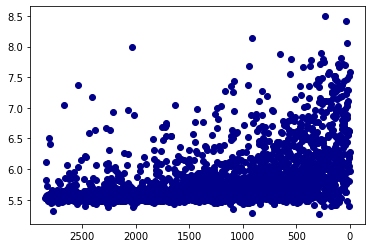

In [ ]:
plt.scatter(x=final_ranked.ks_rank,
                y=final_ranked.bayes_rating,
                c='DarkBlue')
ax = plt.gca()
ax.set_xlim(ax.get_xlim()[::-1])

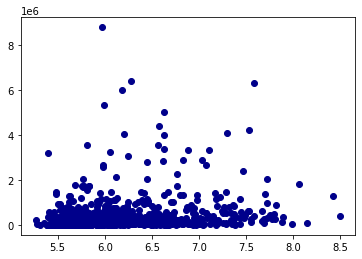

In [ ]:
plt.scatter(x=final_ranked.bayes_rating,
                y=final_ranked.usd_pledged,
                c='DarkBlue')

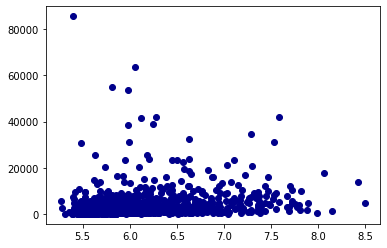

In [ ]:
plt.scatter(x=no_multi_df.bayes_rating,
                y=no_multi_df.backers_count,
                c='DarkBlue')

In [ ]:
final_ranked.columns.values

array(['bgg_id', 'name', 'rank', 'year', 'alt_name', 'artist',
       'avg_rating', 'bayes_rating', 'category', 'complexity',
       'description', 'designer', 'family', 'game_type',
       'language_dependency', 'max_players', 'max_players_best',
       'max_players_rec', 'max_time', 'mechanic', 'min_age',
       'min_age_rec', 'min_players', 'min_players_best',
       'min_players_rec', 'min_time', 'num_votes', 'publisher',
       'stddev_rating', 'url', 'video_url', 'expansion', 'cooperative',
       'game_type_Abstract Game', 'game_type_Amiga', 'game_type_Arcade',
       'game_type_Atari ST', "game_type_Children's Game",
       'game_type_Commodore 64', 'game_type_Customizable',
       'game_type_Family Game', 'game_type_Party Game',
       'game_type_Strategy Game', 'game_type_Thematic',
       'game_type_War Game', 'mechanic_Acting',
       'mechanic_Action Drafting', 'mechanic_Action Points',
       'mechanic_Action Queue', 'mechanic_Action Retrieval',
       'mechanic_Action Ti

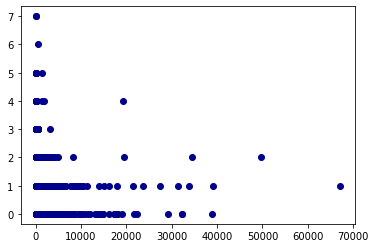

In [ ]:
plt.scatter(x=final_ranked.num_votes,
                y=final_ranked.release_delta,
                c='DarkBlue')

In [ ]:
final_ranked[['bayes_rating','release_delta','usd_pledged']].corr(method='spearman')

,bayes_rating,release_delta,usd_pledged
bayes_rating,1.00000,0.10872,0.56250
release_delta,0.10872,1.00000,0.20954
usd_pledged,0.56250,0.20954,1.00000


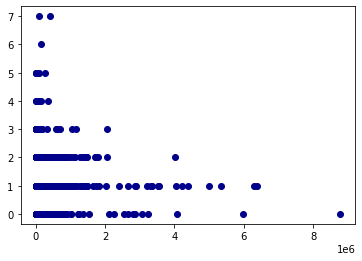

In [ ]:
plt.scatter(x=final_ranked.usd_pledged,
                y=final_ranked.release_delta,
                c='DarkBlue')

(2982.975, -140.475)

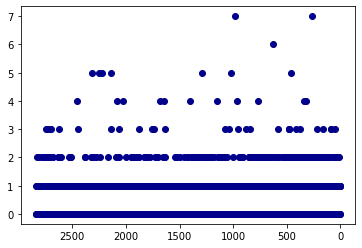

In [ ]:
plt.scatter(x=final_ranked.ks_rank,
                y=final_ranked.release_delta,
                c='DarkBlue')

ax = plt.gca()
ax.set_xlim(ax.get_xlim()[::-1])

In [ ]:
filter_col = [col for col in final_ranked if col.startswith('game_type_')]

In [ ]:
def col_describe(col):
   desc = final_ranked.groupby(col).describe()[['ks_rank','usd_pledged','backers_count','bayes_rating','avg_rating','complexity','num_votes']]
   return desc

def dict_compare(frame, test_field, test_func='mean', comp_type='game_type_'):
    filter = [col for col in frame if col.startswith(comp_type)]
    value_pairs = [(val,getattr(frame.groupby([val])[test_field],test_func)()) for val in filter]
    comp = []
    for x in value_pairs:
      try:
        comp.append((x[0],x[1][1]))
      except:
        pass
    return sorted([x for x in comp if x[1] == x[1]], key=lambda tup: tup[1], reverse=True)

In [ ]:
describes = [col_describe(col) for col in filter_col]

In [ ]:
pd.options.display.max_columns = 400
print(describes[10])

                     ks_rank                                         \
                       count       mean       std     min       25%   
game_type_Thematic                                                    
0.00000            833.00000 1191.00060 786.31908 1.50000 511.00000   
1.00000            285.00000  788.42632 719.24526 3.50000 217.50000   

                                                    usd_pledged               \
                          50%        75%        max       count         mean   
game_type_Thematic                                                             
0.00000            1097.00000 1787.00000 2834.00000   833.00000 197027.08864   
1.00000             532.50000 1203.00000 2802.00000   285.00000 501977.50660   

                                                                     \
                            std        min         25%          50%   
game_type_Thematic                                                    
0.00000            543412.7343

# Categories

In [ ]:
cat_rank = list(dict_compare(final_ranked,'ks_rank', comp_type='category_', test_func='count'))

In [ ]:
cat_back = list(dict_compare(final_ranked,'backers_count', comp_type='category_', test_func='median'))[0:10]

In [ ]:
cat_fund = list(dict_compare(final_ranked,'usd_pledged', comp_type='category_', test_func='median'))[0:10]

In [ ]:
cat_filter = [x[0] for x in cat_rank if x[1] > 200]
corr_set = ['ks_rank','usd_pledged','backers_count','per_backer_contribution']
cat_filter.extend(corr_set)
test_frame = final_ranked[final_ranked['Crowdfunding: Kickstarter'] == 1][[corr_set[0],cat_filter[3]]].dropna()

In [ ]:
cat_filter

['category_Card Game',
 'category_Fantasy',
 'category_Fighting',
 'category_Science Fiction',
 'category_Dice',
 'category_Adventure',
 'category_Miniatures',
 'category_Wargame',
 'category_Humor',
 'category_Party Game',
 'category_Exploration',
 'category_Economic',
 'category_Horror',
 'ks_rank',
 'usd_pledged',
 'backers_count',
 'per_backer_contribution']

In [ ]:
dict_compare(final_ranked,'avg_pledge', comp_type='category_', test_func='mean')

[('category_Miniatures', 135.67241465608697),
 ('category_Collectible Components', 121.24599728739453),
 ('category_World War II', 111.15410241614825),
 ('category_Electronic', 108.42867108229674),
 ('category_World War I', 107.48237565775922),
 ('category_Modern Warfare', 104.38146499812525),
 ('category_American Revolutionary War', 103.10739689536939),
 ('category_Pike and Shot', 98.69264486843893),
 ('category_Wargame', 98.20039246601506),
 ('category_Vietnam War', 95.4939756200082),
 ('category_Comic Book / Strip', 91.47742443164061),
 ('category_Korean War', 89.79710144927536),
 ('category_Napoleonic', 89.41325451650756),
 ('category_Fighting', 87.2467831865254),
 ('category_Zombies', 85.87297379271656),
 ('category_Adventure', 84.70968427153753),
 ('category_Horror', 84.06825489299617),
 ('category_Video Game Theme', 81.26195818419323),
 ('category_Age of Reason', 81.23391345438878),
 ('category_Exploration', 79.92796011277382),
 ('category_American Indian Wars', 78.8849484484439

In [ ]:
final_ranked['avg_pledge'].mean()

62.48938340744114

In [ ]:
final_ranked[cat_filter].corr(method='spearman')[corr_set].drop(corr_set)

,ks_rank,usd_pledged,backers_count,per_backer_contribution
category_Card Game,0.14726,-0.22445,-0.06992,0.06923
category_Fantasy,-0.13570,0.14490,0.12603,-0.12576
category_Fighting,-0.13620,0.16346,0.10678,-0.10660
category_Science Fiction,-0.08730,0.10060,0.07619,-0.07601
category_Dice,-0.00528,0.01929,-0.00174,0.00196
category_Adventure,-0.16451,0.18641,0.13795,-0.13779
category_Miniatures,-0.26025,0.32467,0.19354,-0.19345
category_Wargame,0.05401,0.01716,-0.11345,0.11370
category_Humor,0.05384,-0.06518,-0.03843,0.03863
category_Party Game,0.07123,-0.09646,-0.04384,0.04406


In [ ]:
del filter_col[1:4]

In [ ]:
0.0009656714358354955 * 100

0.09656714358354955

# Release Channel + Year Data

In [ ]:
groupby_ks = final_ranked.groupby('Crowdfunding: Kickstarter')
groupby_ks.size()

Crowdfunding: Kickstarter
0.00000    15401
1.00000     2834
dtype: int64

In [ ]:
groupby_ks['year'].min()

Crowdfunding: Kickstarter
0.00000   -3500
1.00000    2009
Name: year, dtype: int64

In [ ]:
final_ranked[final_ranked['year'] > 2008].groupby('Crowdfunding: Kickstarter').size()

Crowdfunding: Kickstarter
0.00000    8046
1.00000    2834
dtype: int64

In [ ]:
groupby_year_ks = final_ranked.groupby(['year', 'Crowdfunding: Kickstarter'])
year_ks = groupby_year_ks.size().unstack()
year_ks.columns = ['Non-KS', 'KS']
year_ks.index.names = ['Year']

In [ ]:
fig = px.bar(year_ks.loc[year_ks.index >= 2000],
             barmode='group',
              color_discrete_map={
                  'KS': '#08ce78',
                  'Non-KS': '#3f3a5f'
              },
             template='plotly_white',
             labels={'value': 'BGG-Ranked Games Published'})
fig.update_layout(showlegend=False)
fig.show()

In [ ]:
fig = go.Figure()

df = final_ranked[final_ranked['year'] > 2008]

fig.add_trace(go.Violin(x=df[df['Crowdfunding: Kickstarter'] == 0]['year'],
                        y=df[df['Crowdfunding: Kickstarter'] == 0]['bayes_rating'],
                        legendgroup='Non-KS', scalegroup='Non-KS', name='Non-KS',
                        side='negative',
                        line_color='purple')
             )
fig.add_trace(go.Violin(x=df[df['Crowdfunding: Kickstarter'] == 1]['year'],
                        y=df[df['Crowdfunding: Kickstarter'] == 1]['bayes_rating'],
                        legendgroup='KS', scalegroup='KS', name='KS',
                        side='positive',
                        line_color='green')
             )
fig.update_traces(meanline_visible=True)
fig.update_layout(violingap=0, violinmode='overlay')
fig.show()

In [ ]:
df[df['Crowdfunding: Kickstarter'] == 0]['bayes_rating'].mean()

5.757787807606265

In [ ]:
df[df['Crowdfunding: Kickstarter'] == 1]['bayes_rating'].mean()

5.777826104446014

In [ ]:
df[df['Crowdfunding: Kickstarter'] == 0]['bayes_rating'].std()

0.4239352329769771

In [ ]:
df[df['Crowdfunding: Kickstarter'] == 1]['bayes_rating'].std()

0.42741872644877593

In [ ]:
fig = px.strip(df, x="year", y="bayes_rating", color="Crowdfunding: Kickstarter",
               color_discrete_map={
                  'KS': 'green',
                  'Non-KS': 'purple'
               })
fig.show()

In [ ]:
q90 = final_ranked['bayes_rating'].quantile(.9)
groupby_year_ks90 = final_ranked[final_ranked['bayes_rating'] >= q90].groupby(['year', 'Crowdfunding: Kickstarter'])
year_ks90 = groupby_year_ks90.size().unstack()
year_ks90.columns = ['Non-KS', 'KS']

fig = px.bar(year_ks90.loc[year_ks90.index >= 2008],
             barmode='group',
              color_discrete_map={
                  'KS': '#08ce78',
                  'Non-KS': '#3f3a5f'
              },
             template='plotly_white',
             labels={'value': 'Games Published w/Top 10% BGG Bayes Rating', 'year': 'Year'})
fig.update_layout(showlegend=False)
fig.show()

In [ ]:
q90 = final_ranked['avg_rating'].quantile(.9)
groupby_year_ks90 = final_ranked[final_ranked['avg_rating'] >= q90].groupby(['year', 'Crowdfunding: Kickstarter'])
year_ks90 = groupby_year_ks90.size().unstack()
year_ks90.columns = ['Non-KS', 'KS']

fig = px.bar(year_ks90.loc[year_ks90.index >= 2008],
             barmode='group',
              color_discrete_map={
                  'KS': '#08ce78',
                  'Non-KS': '#3f3a5f'
              },
             template='plotly_white',
             labels={'value': 'Games Published w/Top 10% BGG Avg. Rating', 'year': 'Year'})
fig.update_layout(showlegend=False)
fig.show()

In [ ]:
bayes_spearman = final_ranked.corr(method='spearman')['bayes_rating'].sort_values(ascending=False)
ks_spearman = final_ranked.corr(method='spearman')['ks_rank'].sort_values(ascending=False)

In [ ]:
combined_spearman = bayes_spearman.to_frame().join(ks_spearman * -1)
combined_spearman = combined_spearman[combined_spearman['bayes_rating'] / combined_spearman['ks_rank'] < 0]
combined_spearman = combined_spearman.drop(index=['usd_exchange_rate', 'fx_rate', 'static_usd_rate'])
combined_spearman = combined_spearman.stack().reset_index()
combined_spearman.columns = ['Feature', 'Platform', 'Correlation']
combined_spearman['Feature'] = combined_spearman['Feature'].map(lambda x: (x[0].upper() + x[1:]).replace('_', ': '))
combined_spearman.iloc[0, 0] = 'Game type: Family Game'
combined_spearman.iloc[1, 0] = 'Game type: Family Game'
fig = px.scatter(combined_spearman, x="Correlation", y="Feature", color="Platform",
                 color_discrete_map={
                  'ks_rank': '#08ce78',
                  'bayes_rating': '#3f3a5f'
                  },
                  template='plotly_white',
                 width=550, height=1200)
fig.layout.yaxis.side = 'right'
fig.update_layout(showlegend=False)
fig.show()

In [ ]:
def createCategoryHeatmap(df, top_pledge_percent, top_category_percent):
    top_category_percent = 100 - top_category_percent
    
    rank_df = df[df['ks_rank'].notna()].sort_values('usd_pledged', ascending=True)
    rank_df = rank_df.head(int(len(rank_df)*(top_pledge_percent/100)))

    category_cols = [x for x in rank_df.columns if 'category_' in x]
    df_category = rank_df[category_cols]
    df_category.columns = df_category.columns.str.replace('category_', '')
    df_category = df_category.fillna(0)

    adj = pd.DataFrame()

    for column in list(df_category.columns):
        t_df = pd.DataFrame(df_category[df_category[column] != 0].sum()).reset_index()
        adj = pd.concat([adj, t_df[0]], ignore_index=True, sort=False, axis=1)

    adj.columns = df_category.columns
    adj.index = df_category.columns
    np.fill_diagonal(adj.values, 0)


    keep = adj.sum().sort_values(ascending=True).to_frame()
    keep = list(keep.head(int(len(keep)*(top_category_percent/100))).index)

    adj = adj.drop(keep)
    adj = adj.drop(keep, axis=1)

    order = list(adj.sum().sort_values(ascending=True).index)
    
    adj = pd.melt(adj.reset_index(), id_vars=['index'])
    adj = adj[adj['value']!=0]

    chart = alt.Chart(adj).mark_rect().encode(
                alt.X('index:N', sort=order, title=None),
                alt.Y('variable:N', sort=order, title=None),
                alt.Color('value:Q',
                    scale=alt.Scale(scheme='greenblue'),
                    legend=None
                )
            ).properties(width=550,height=550)
    
    text = alt.Chart(adj).mark_text(baseline='middle').encode(
                alt.X('index:N', sort=order),
                alt.Y('variable:N', sort=order),
                text=alt.Text('value:Q'),
            )

    return chart + text

In [ ]:
createCategoryHeatmap(final_ranked, 30, 20)

alt.LayerChart(...)